# Seasonal Claim Arrivals

Here, we set the claim arrival process to be governed by an inhomogenous Poisson process $N_t$ with intensity function 

$$
\lambda(t) = a + b[1 + \sin(2\pi c t)]
$$

The claim frequency data $n_s,\,s = 1,\ldots, t$ correspond to the increments of this non homogeneous Poisson process. These are independent Poisson variables $\text{Pois}\big(\mu(s)\big)$ with 

$$
\mu(s) = \int_{s}^{s+1} \lambda(u) \,\mathrm{d}u = a + b + \frac{b}{2\pi c}\left[\cos(2\pi c s) - \cos(2\pi c (s+1))\right],\quad s = 1,\ldots, t \,.
$$

The claim sizes are $U_{i,j} \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Pareto}(\mu, \alpha)$ where the $\mu$ is the scale parameter and $\alpha$ is the shape parameter.

The available data is the total claim sizes
$$
X_i = \sum_{j = 1}^{N_i} U_{i,j}, \quad i = 1, \ldots, T.
$$

## Generate synthetic observations

In [1]:
%config InlineBackend.figure_format = 'retina'
%run preamble.py
import approxbayescomp as abc
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Parameters of the true model
freq = "cyclical_poisson"
sev = "pareto"

a = 1
b = 5
c = 1 / 50

scale = 10
tail = 2

trueTheta = (a, b, c, scale, tail)

# Setting the time horizon
T = 250

# Simulating the claim data
rg = rnd.default_rng(123)
freqs, sevs = abc.simulate_claim_data(rg, T, freq, sev, trueTheta)

# Simulating the observed data
psi = abc.Psi("sum")
xData = abc.compute_psi(freqs, sevs, psi)

## Plot the cyclical observations against their expected values

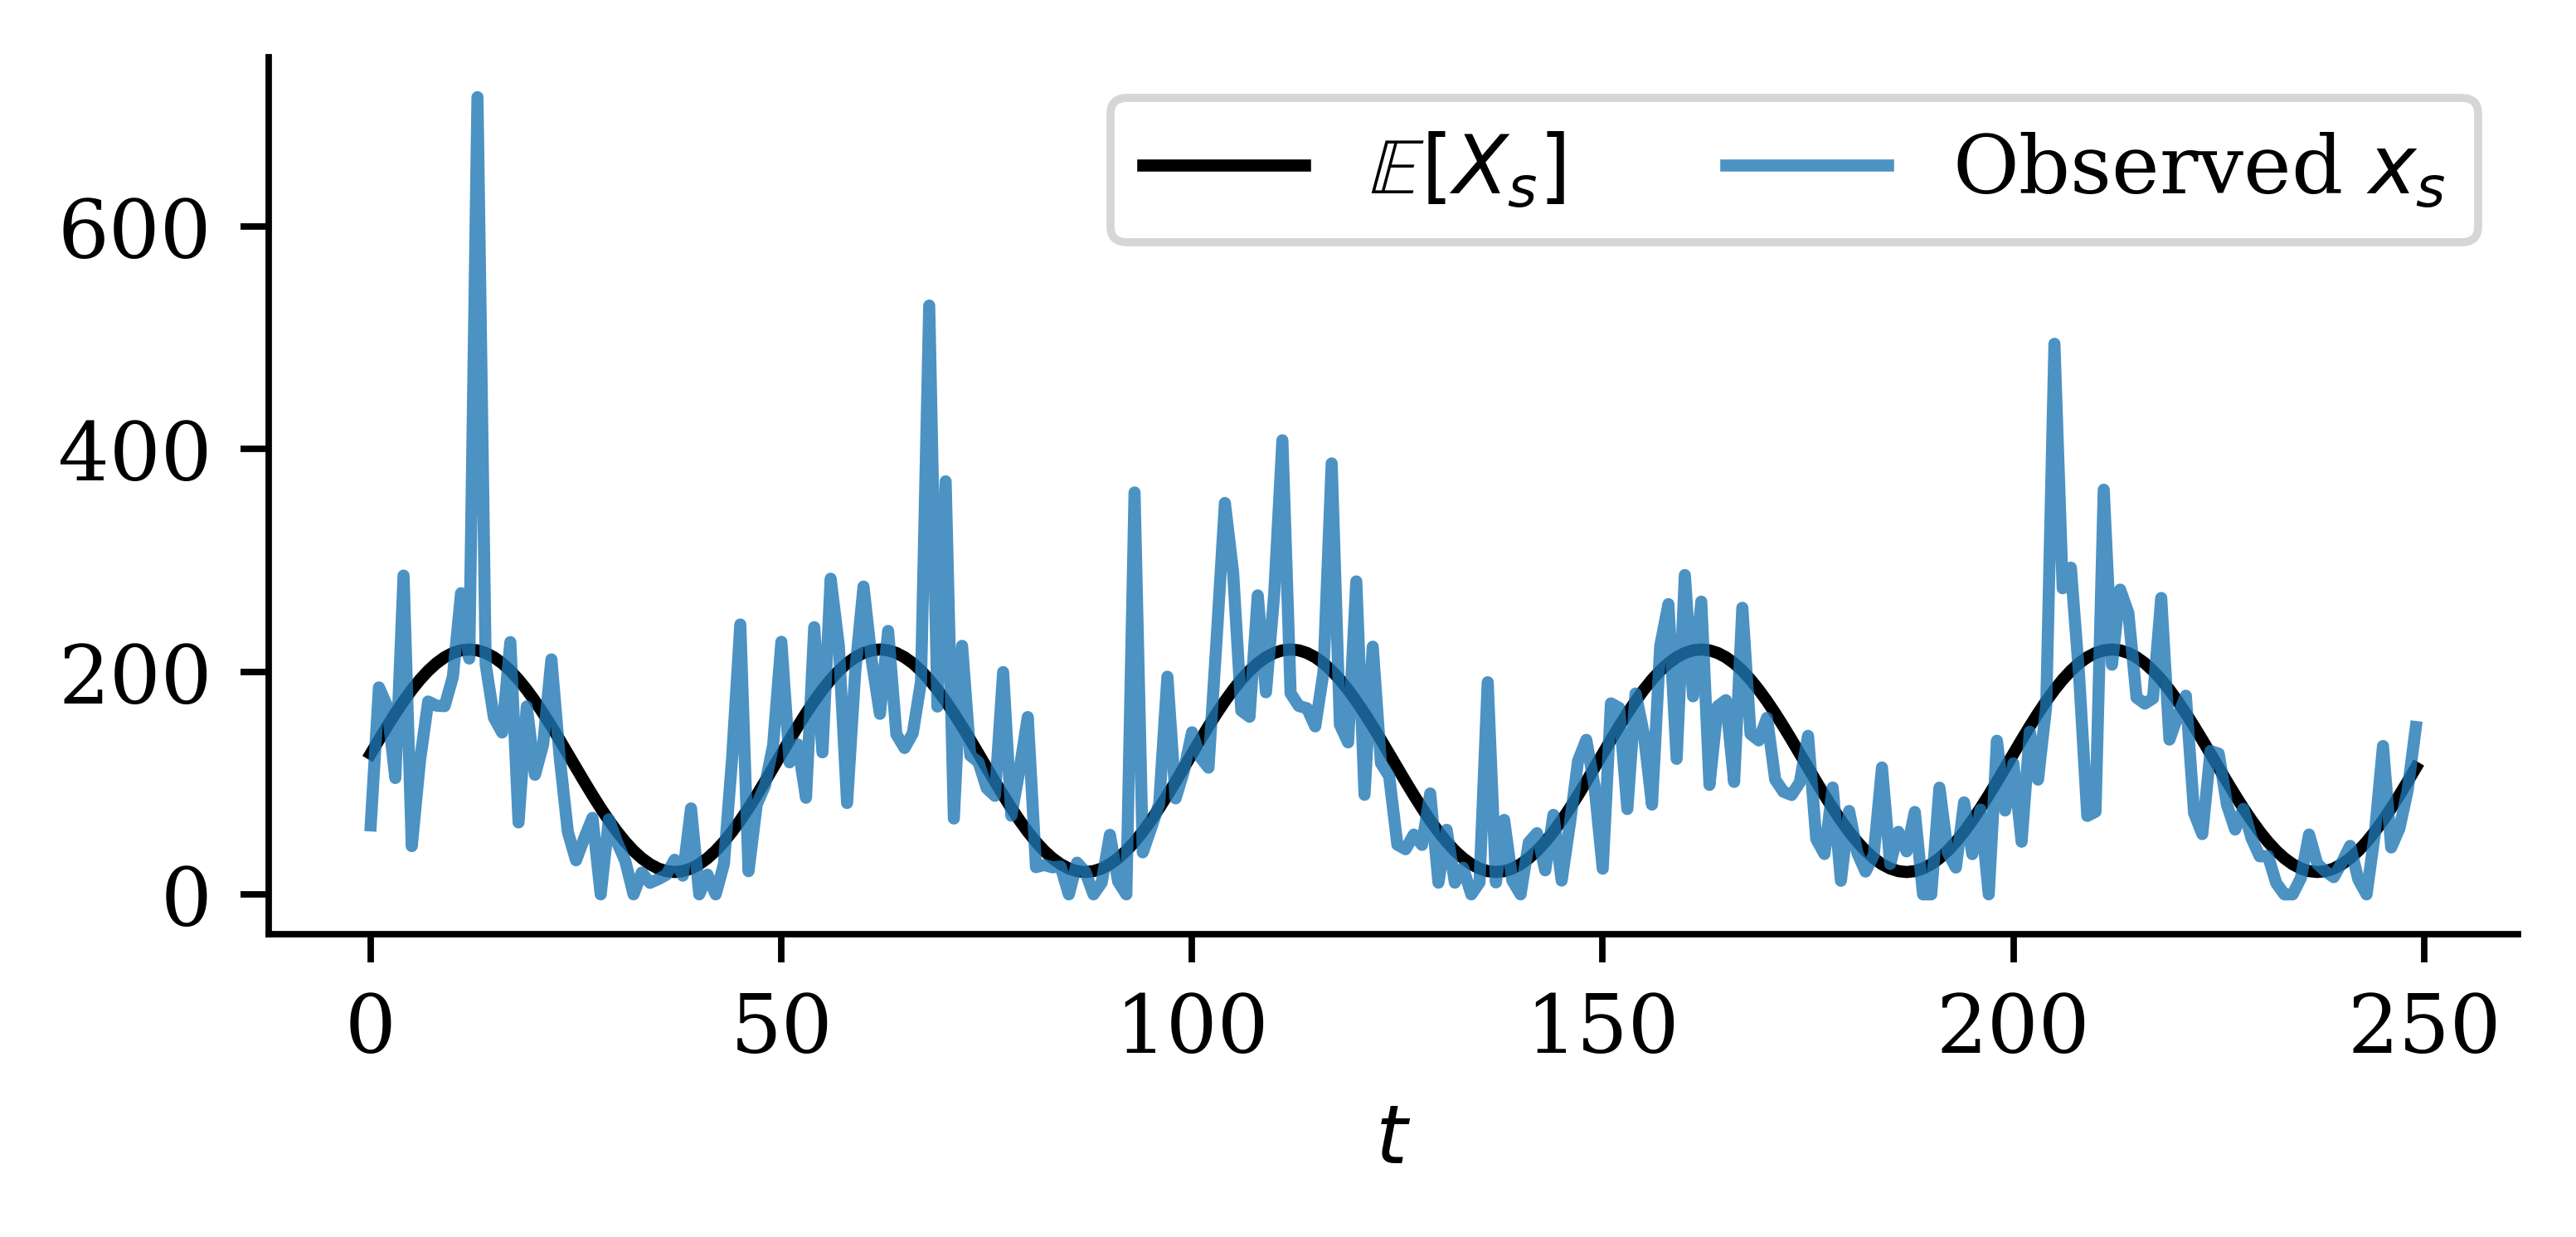

In [3]:
t = np.arange(T)
cosTerms = np.cos(2 * np.pi * c * t) - np.cos(2 * np.pi * (t + 1) * c)
freqMean = a + b + (b / (2 * np.pi * c)) * cosTerms
severityMean = scale * tail / (tail - 1)
xMean = freqMean * severityMean

plt.plot(t, xMean, label="$\mathbb{E}[X_s]$", c="k")
plt.plot(t, xData, label="Observed $x_s$", alpha=0.8)

plt.xlabel("$t$")
plt.legend(ncol=2)
sns.despine()

## Try a time series distance function

As we normally assume that we observe independent and identically distributed data, the default distance function in `smc` does not take into account the order of the observations.
For this example, we need to swap out the distance measure with one which is designed for time series comparison.

Here, we use the _dynamic time warping_ distance, with the implementation from the [_dtaidistance_ package](https://dtaidistance.readthedocs.io/).
To illustrate this distance, we simulate some more data from the true data-generating process:

In [4]:
rg = rnd.default_rng(456)
freqs2, sevs2 = abc.simulate_claim_data(rg, T, freq, sev, trueTheta)
xData2 = abc.compute_psi(freqs2, sevs2, psi)

Plotting the original $x_s$ data alongside this new $x_s'$ data:

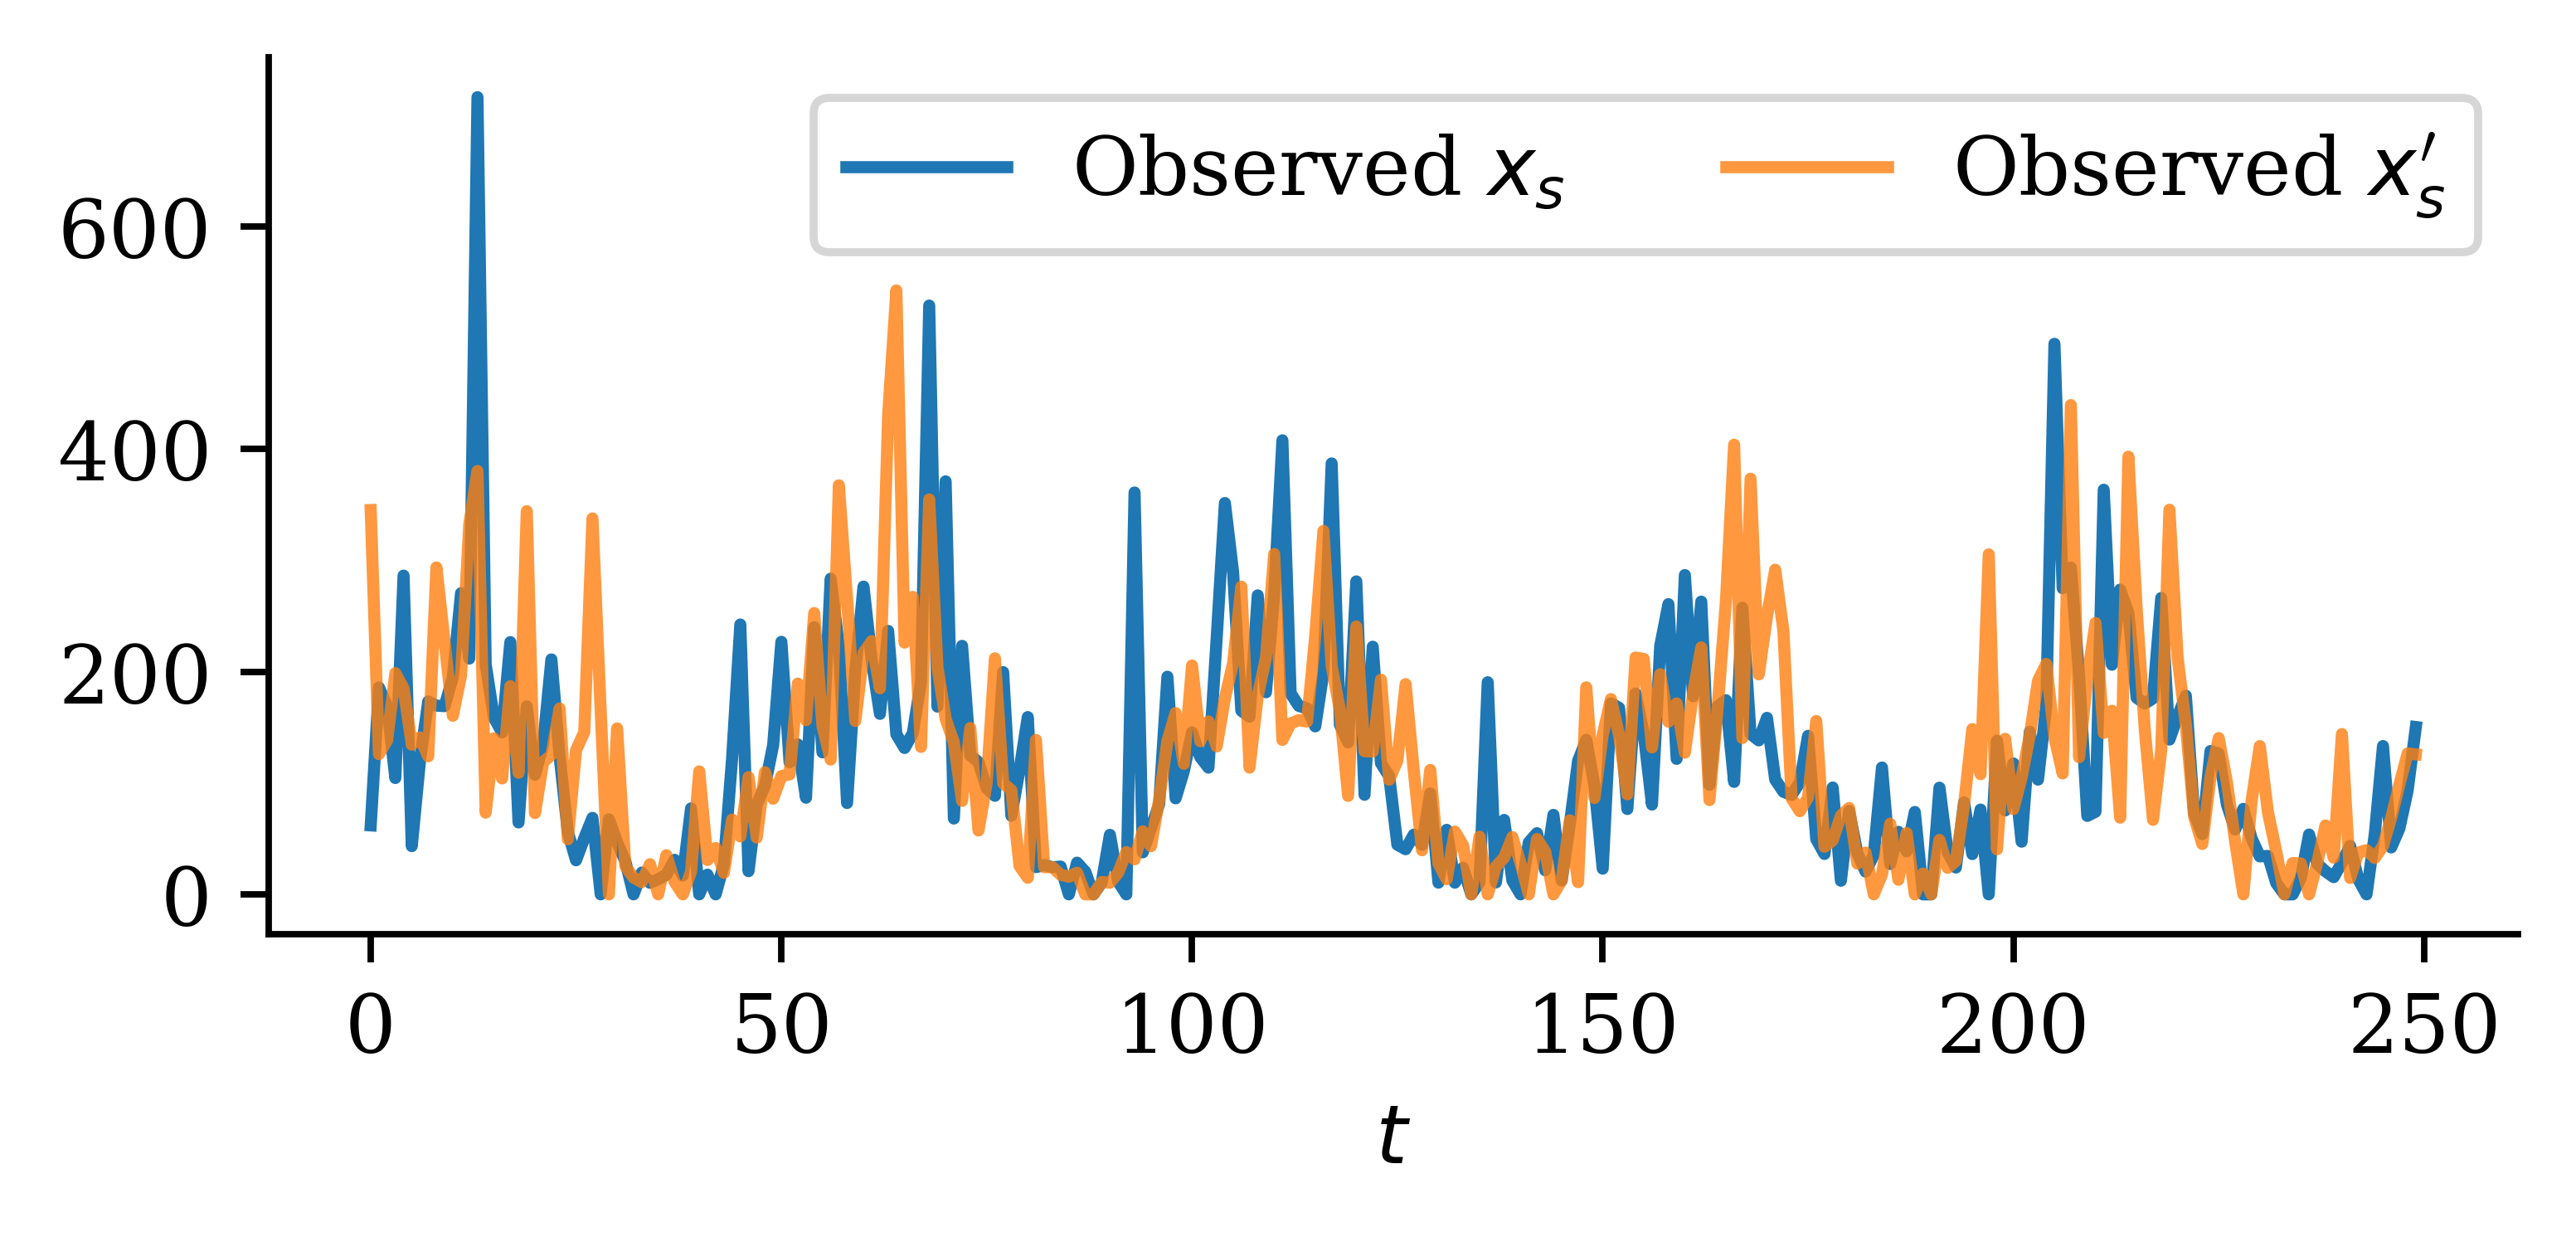

In [5]:
plt.plot(t, xData, label="Observed $x_s$")
plt.plot(t, xData2, label="Observed $x_s'$", alpha=0.8)
plt.xlabel("$t$")
plt.legend(ncol=3)
sns.despine()

The dynamic time warping method speeds up and slows down the time in one time series to better match the other time series. The `dtaidistance` package has a built-in visualisation to show this matching between the series:

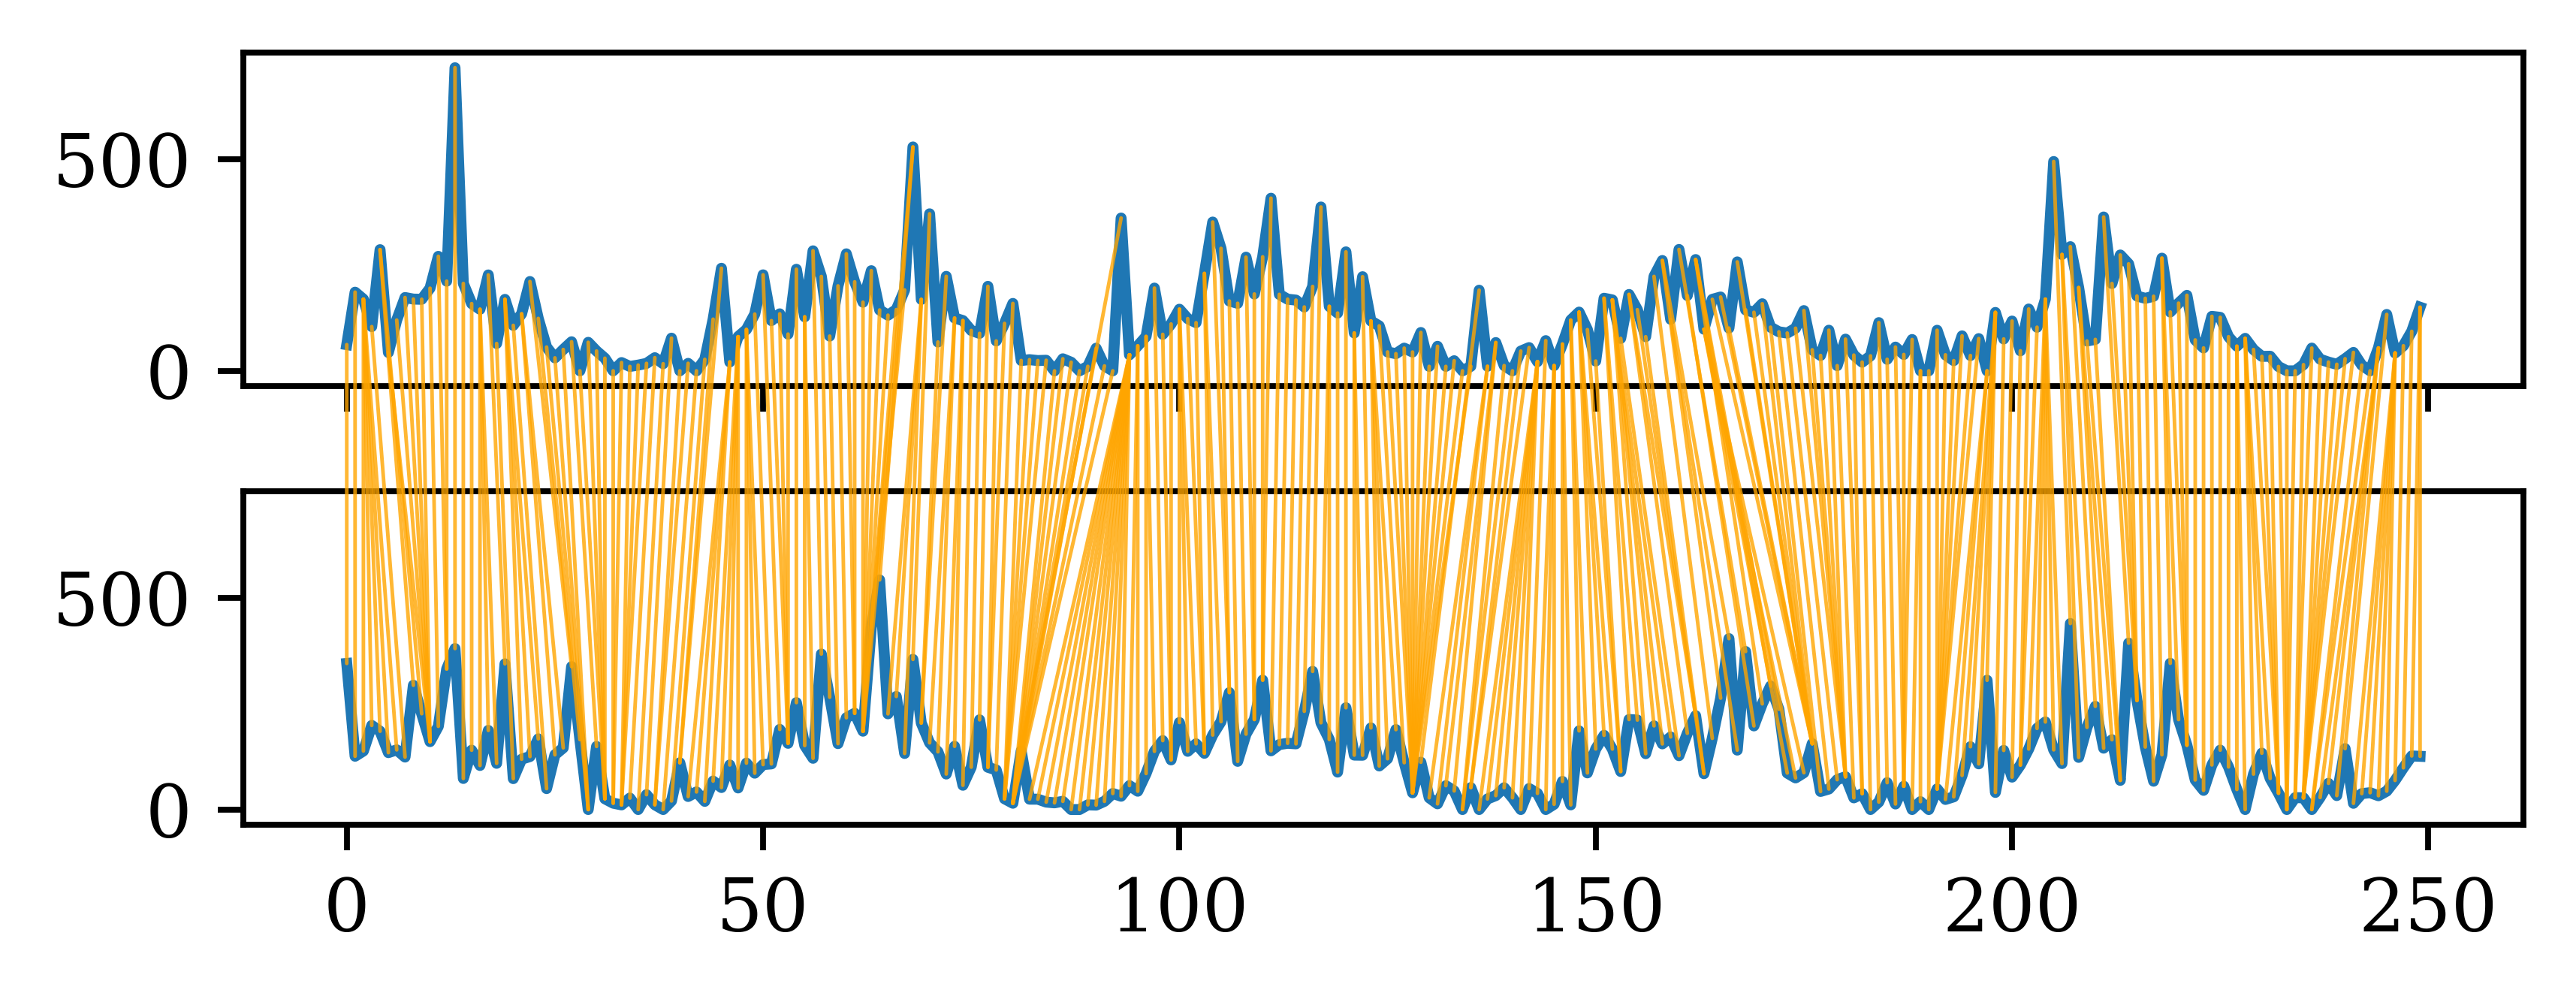

In [6]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

path = dtw.warping_path(xData, xData2)
fig = dtwvis.plot_warping(xData, xData2, path)

## Use ABC to fit the data

With this data, we create objects to represent the data-generating process (the model) and the prior distribution.
The priors are set as

$$
a \sim \mathsf{Unif}(0, 50), \quad b \sim \mathsf{Unif}(0, 50), \quad c \sim \mathsf{Unif}(\frac{1}{1000}, \frac{1}{10})
$$
$$
\mu \sim \mathsf{Unif}(0, 50), \quad \text{ and } \quad \alpha \sim \mathsf{Unif}(1, 10) \,.
$$

In [7]:
model = abc.Model("cyclical_poisson", "pareto", psi)
prior = abc.IndependentUniformPrior(
    [(0, 50), (0, 50), (1 / 1000, 1 / 10), (0, 50), (1, 10)]
)

In [8]:
numIters = 14
popSize = 200

%time fit = abc.smc(numIters, popSize, xData, model, prior, sumstats=abc.identity, distance=dtw.distance, numProcs=40)

CPU times: user 1.73 s, sys: 861 ms, total: 2.6 s
Wall time: 4min 22s


These particles all generated fake data within the following distance to the observed data:

In [9]:
np.max(fit.dists)

836.5731499601759

Plotting the fitted ABC posterior:

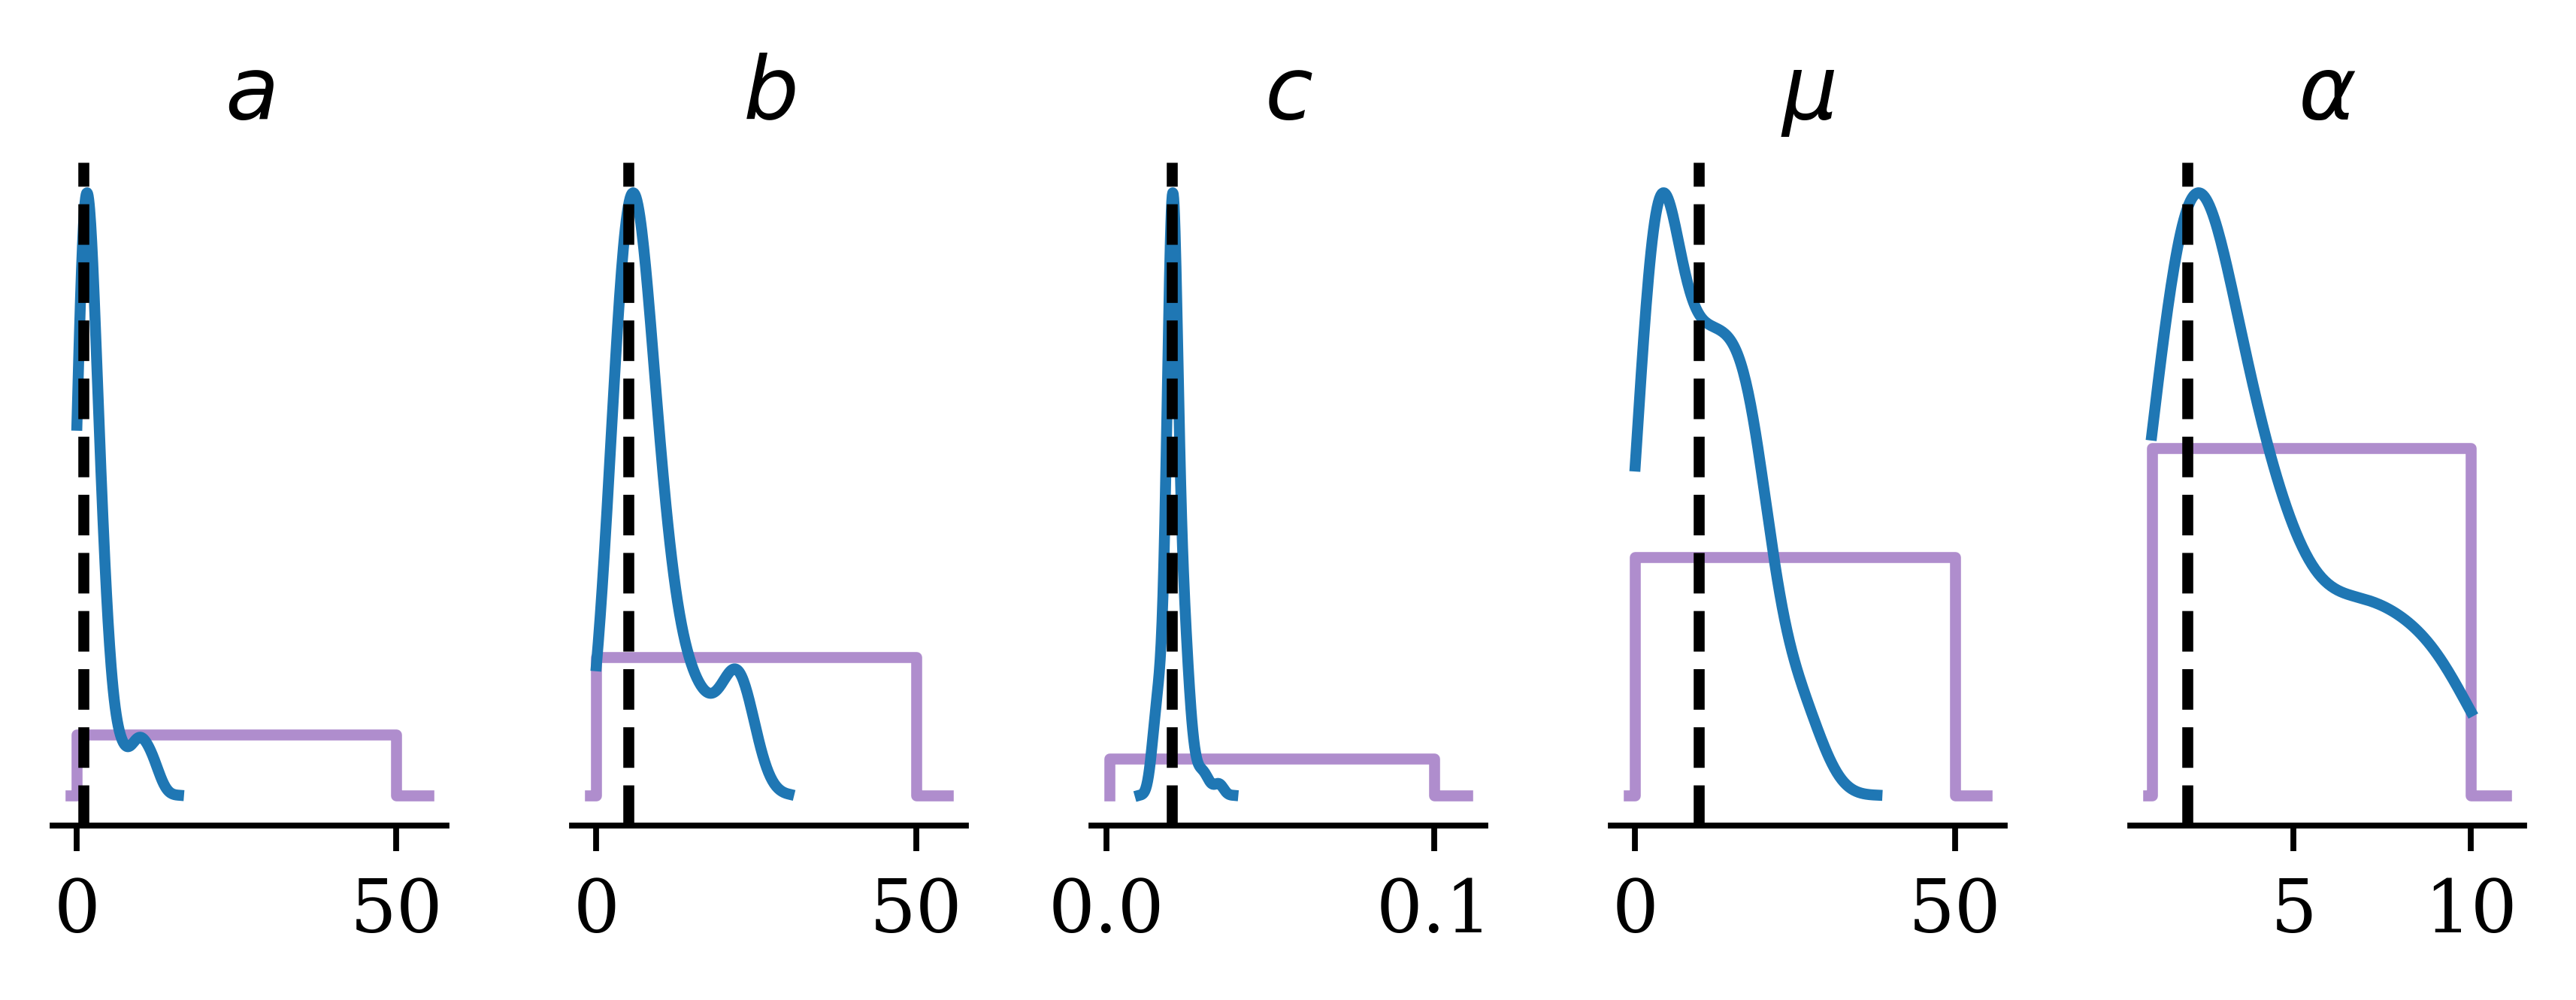

In [10]:
params = ("$a$", "$b$", "$c$", "$\\mu$", "$\\alpha$")
abc.plot_posteriors(
    fit,
    prior,
    subtitles=params,
    refLines=trueTheta,
    removeYAxis=True,
)